In [ ]:
!pip install tslearn

     |████████████████████████████████| 798kB 3.0MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)
from tslearn.metrics import dtw, dtw_path
from tslearn.generators import random_walks
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn import metrics
from scipy.spatial import distance
import numpy as np
from tslearn.metrics import dtw, dtw_path
from tslearn.clustering import TimeSeriesKMeans
from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram
from scipy.cluster.hierarchy import fcluster
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()

/usr/local/lib/python3.7/dist-packages/tslearn/clustering/kmeans.py:17: UserWarning:

Scikit-learn <0.24 will be deprecated in a future release of tslearn



In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Covid19ClusterPrediction/raw_data_state_wise.csv")

In [ ]:
df.tail()

del df['Status-C']
del df['Status-R']
del df['Status-D']
del df['Status-T']

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']
del df['Date']
# del df['Unnamed: 0']
df.tail()

TT-C   TT-R  TT-D  TT-T  AN-C  ...  WB-T  UN-C  UN-R  UN-D  UN-T
Date                                        ...                              
2021-01-07  18123  20503   233     0     9  ...     0     0     0     0     0
2021-01-08  18453  19242   229     0     1  ...     0     0     0     0     0
2021-01-09  18820  19460   213     0     0  ...     0     0     0     0     0
2021-01-10  16086  16737   150     0     1  ...     0     0     0     0     0
2021-01-11  12481  18578   166     0     3  ...     0     0     0     0     0

[5 rows x 156 columns]

Converting it into a time series

In [ ]:
cols=list(df.columns)

In [ ]:
current_ds=df[list(cols[i] for i in filter(lambda i:i%4==0, range(len(cols))))]
current_ds.tail()

TT-C  AN-C  AP-C  AR-C  AS-C  ...  TR-C  UP-C  UT-C  WB-C  UN-C
Date                                       ...                              
2021-01-07  18123     9   295     4    57  ...     8   503   249   921     0
2021-01-08  18453     1   319     7    50  ...     5   767   269   926     0
2021-01-09  18820     0   199     3    34  ...     0  1286   287   787     0
2021-01-10  16086     1   227     5    25  ...     8   275   223   823     0
2021-01-11  12481     3   121     5    45  ...     0   509   156   612     0

[5 rows x 39 columns]

In [ ]:
recovered_ds=df[list(cols[i] for i in filter(lambda i:i%4==1, range(len(cols))))]
recovered_ds.tail()

TT-R  AN-R  AP-R  AR-R  AS-R  ...  TR-R  UP-R  UT-R  WB-R  UN-R
Date                                       ...                              
2021-01-07  20503     5   368    13    48  ...     8   646   439  1295     0
2021-01-08  19242     2   308     9    54  ...     9  1001   390  1136     0
2021-01-09  19460     7   423    16    56  ...     0  1375   243   978     0
2021-01-10  16737     2   289     3    29  ...    10   561   303   957     0
2021-01-11  18578     9   213     8    64  ...     7   770   523   939     0

[5 rows x 39 columns]

In [ ]:
deceased_ds=df[list(cols[i] for i in filter(lambda i:i%4==2, range(len(cols))))]
deceased_ds.tail()

TT-D  AN-D  AP-D  AR-D  AS-D  ...  TR-D  UP-D  UT-D  WB-D  UN-D
Date                                      ...                              
2021-01-07   233     0     1     0     2  ...     0    10     6    18     0
2021-01-08   229     0     1     0     0  ...     1    17     7    21     0
2021-01-09   213     0     1     0     1  ...     0    24     6    20     0
2021-01-10   150     0     1     0     1  ...     0     2     5    19     0
2021-01-11   166     0     2     0     3  ...     0     9     5    16     0

[5 rows x 39 columns]

In [ ]:
total_ds=df[list(cols[i] for i in filter(lambda i:i%4==3, range(len(cols))))]
total_ds.tail()

TT-T  AN-T  AP-T  AR-T  AS-T  ...  TR-T  UP-T  UT-T  WB-T  UN-T
Date                                      ...                              
2021-01-07     0     0     0     0     0  ...     0     0     0     0     0
2021-01-08     0     0     0     0     0  ...     0     0     0     0     0
2021-01-09     0     0     0     0     0  ...     0     0     0     0     0
2021-01-10     0     0     0     0     0  ...     0     0     0     0     0
2021-01-11     0     0     0     0     0  ...     0     0     0     0     0

[5 rows x 39 columns]

In [ ]:
# current_ds.to_csv("/content/drive/MyDrive/Covid19ClusterPrediction/raw_data_state_wise_current.csv")
# recovered_ds.to_csv("/content/drive/MyDrive/Covid19ClusterPrediction/raw_data_state_wise_recovered.csv")
# deceased_ds.to_csv("/content/drive/MyDrive/Covid19ClusterPrediction/raw_data_state_wise_deceased.csv")
# total_ds.to_csv("/content/drive/MyDrive/Covid19ClusterPrediction/raw_data_state_wise_total.csv")

In [ ]:
def getDTWPath_and_Score(dataset):
  cols=list(dataset.columns)
  pathDs=pd.DataFrame(columns=cols)
  scoreDs=pd.DataFrame(columns=cols)
  pathDs['Names']=[]
  scoreDs['Names']=[]
  # print(scoreDs)
  for i in range(len(cols)):
    path_list=[]
    score_list=[]
    for j in range(len(cols)):
      optimal_path, dtw_score = dtw_path(dataset[cols[i]], dataset[cols[j]])  # ADDITIONAL CONSTRAINT
      path_list.append(optimal_path)
      score_list.append(dtw_score)
    path_list.append(cols[i])
    score_list.append(cols[i])
    # print(score_list)
    pathDs.loc[len(pathDs.index)]=path_list
    scoreDs.loc[len(scoreDs.index)]=score_list
    # print(scoreDs)
  return pathDs,scoreDs

In [ ]:
def createDTWScoreDS(dataset,DSName):
  pathDs,scoreDs=getDTWPath_and_Score(current_ds)
  scoreDs.index=scoreDs['Names']
  scoreDs.drop(labels='Names',axis=1,inplace=True)
  scoreDs.index.name=None
  scoreDs.to_csv("/content/drive/MyDrive/Covid19ClusterPrediction/raw_data_state_wise_"+str(DSName)+"_DTWScore.csv")
  pathDs.index=pathDs['Names']
  pathDs.drop(labels='Names',axis=1,inplace=True)
  pathDs.index.name=None
  pathDs.to_csv("/content/drive/MyDrive/Covid19ClusterPrediction/raw_data_state_wise_"+str(DSName)+"_DTWPath.csv")

In [ ]:
# createDTWScoreDS(current_ds,"current")
# createDTWScoreDS(recovered_ds,"recovered")
# createDTWScoreDS(deceased_ds,"deceased")
# createDTWScoreDS(total_ds,"total")

In [ ]:
pathDs,scoreDs=getDTWPath_and_Score(current_ds)

In [ ]:
pathDs.tail()

TT-C  ... Names
34  [(0, 0), (1, 1), (2, 2), (3, 3), (4, 3), (5, 3...  ...  TR-C
35  [(0, 0), (0, 1), (0, 2), (1, 3), (2, 3), (3, 3...  ...  UP-C
36  [(0, 0), (1, 1), (2, 2), (3, 3), (4, 3), (5, 3...  ...  UT-C
37  [(0, 0), (1, 1), (2, 2), (3, 3), (4, 3), (5, 3...  ...  WB-C
38  [(0, 0), (1, 1), (2, 2), (3, 3), (4, 3), (5, 3...  ...  UN-C

[5 rows x 40 columns]

In [ ]:
def getDTWScore(dataset):
  cols=list(dataset.columns)
  scoreDs=pd.DataFrame(columns=cols)
  scoreDs['Names']=[]
  # print(scoreDs)
  for i in range(len(cols)):
    score_list=[]
    for j in range(len(cols)):
      dtw_score = dtw(dataset[cols[i]], dataset[cols[j]], global_constraint="sakoe_chiba", sakoe_chiba_radius=7)  # ADDITIONAL CONSTRAINT
      score_list.append(dtw_score)
    score_list.append(cols[i])
    # print(score_list)
    scoreDs.loc[len(scoreDs.index)]=score_list
    # print(scoreDs)
  return scoreDs

In [ ]:
scoreDs=getDTWScore(current_ds)

In [ ]:
scoreDs.index=scoreDs['Names']
scoreDs.drop(labels='Names',axis=1,inplace=True)

In [ ]:
# scoreDs.reset_index(inplace=True)
scoreDs.index.name=None
# scoreDs.to_csv("/content/drive/MyDrive/Covid19ClusterPrediction/raw_data_state_wise_current_DTWScore.csv")
scoreDs

TT-C           AN-C  ...           WB-C           UN-C
TT-C       0.000000  780860.667194  ...  741039.965525  781462.551780
AN-C  780860.667194       0.000000  ...   40798.879899    4030.011042
AP-C  698213.054136   80842.965748  ...   53621.718697   81672.763789
AR-C  779672.405292    1348.902517  ...   39659.264277    4279.764246
AS-C  759685.982063   20016.390784  ...   28107.917888   21047.601740
BR-C  759641.084328   20948.857630  ...   25683.816188   22045.975687
CH-C  779369.191412    1548.491524  ...   39403.200708    4356.139690
CT-C  756178.039672   24183.878949  ...   19823.903501   24723.862967
DN-C  781038.555249     266.401952  ...   41025.121925    4014.138264
DD-C  781307.594389     560.948304  ...   41255.945208    3994.758316
DL-C  738082.156230   49021.268190  ...   21573.475844   49069.453380
GA-C  776695.737384    3904.927784  ...   36930.919932    5956.027535
GJ-C  765495.608103   16137.746187  ...   25473.847020   17113.826574
HR-C  760632.364675   20278.117344  ...   20775.309673   21064.639470
HP-C  777367.856217    4985.280634  ...   36325.729421    6513.747309
JK-C  770873.709246    9197.987062  ...   31749.300307   10360.426873
JH-C  768225.361263   10423.565657  ...   31707.798378   11583.664014
KA-C  696879.034642   78885.201305  ...   46867.944013   79633.323320
KL-C  718142.986613   68452.996078  ...   35354.855522   68801.543580
LA-C  780597.311536     649.201047  ...   40468.925783    3950.322012
LD-C  781307.594389     560.948304  ...   41255.945208    3994.758316
MP-C  758947.630631   18774.933795  ...   23888.460959   19538.358426
MH-C  609264.598210  153278.400549  ...  119014.555648  153894.275004
MN-C  779082.399104    2063.295907  ...   38693.847728    4534.834617
ML-C  779968.514893    1036.986017  ...   39820.717234    4177.983964
MZ-C  780898.452092     405.683374  ...   40829.292524    3973.072740
NL-C  780236.624524     793.413511  ...   40118.142629    4104.454166
OR-C  749470.946862   28980.369649  ...   20189.165981   29763.718400
PY-C  777589.112525    3164.124681  ...   37853.561272    5426.159047
PB-C  764892.921280   14245.795064  ...   28523.655709   15296.470344
RJ-C  759053.992563   22765.137008  ...   17735.314206   23526.061421
SK-C  780800.907071     374.422222  ...   40721.387734    4005.650384
TN-C  720297.196420   60809.781491  ...   31112.561386   61782.809551
TG-C  758214.678426   21603.632033  ...   22189.806624   22636.839642
TR-C  778003.621362    2936.048194  ...   38302.987808    5018.736395
UP-C  728809.041728   47015.154036  ...   20966.037227   47853.682189
UT-C  772306.162329    7481.407889  ...   33423.343040    8643.049867
WB-C  741039.965525   40798.879899  ...       0.000000   41539.745365
UN-C  781462.551780    4030.011042  ...   41539.745365       0.000000

[39 rows x 39 columns]

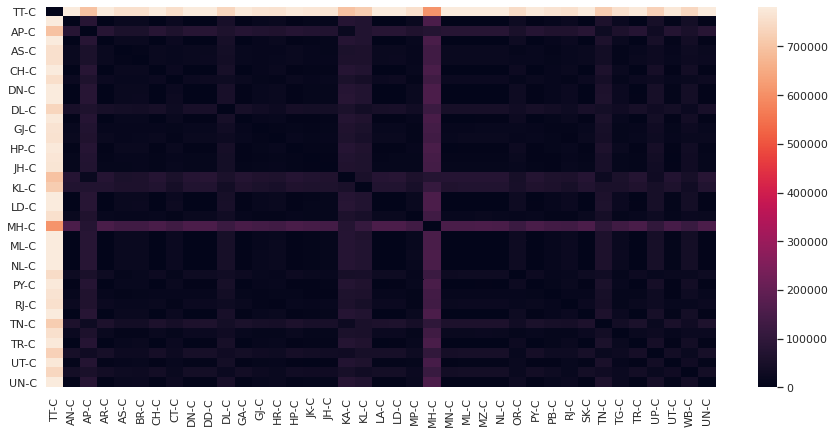

In [ ]:
sns.heatmap(scoreDs) #Without Normalisation

# Normalisation with population

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html

In [ ]:
def hierarchical_clustering(dist_mat, method='complete'):
    if method == 'complete':
        Z = complete(dist_mat)
    if method == 'single':
        Z = single(dist_mat)
    if method == 'average':
        Z = average(dist_mat)
    if method == 'ward':
        Z = ward(dist_mat)

    fig = plt.figure(figsize=(16, 8))
    dn = dendrogram(Z)
    plt.title(f"Dendrogram for {method}-linkage with correlation distance")
    plt.show()

    return Z

In [ ]:
states_map = {
    "Andaman and Nicobar Islands":"AN",
    "Andhra Pradesh":"AP",
    "Arunachal Pradesh":"AR",
    "Assam":"AS",
    "Bihar":"BR",
    "Chandigarh":"CH",
    "Chhattisgarh":"CT",
    "Dadra and Nagar Haveli and Daman and Diu":"DN",
    "Delhi":"DL",
    "Goa":"GA",
    "Gujarat":"GJ",
    "Haryana":"HR",
    "Himachal Pradesh":"HP",
    "Jammu and Kashmir":"JK",
    "Jharkhand":"JH",
    "Karnataka":"KA",
    "Kerala":"KL",
    "Ladakh":"LA",
    "Lakshadweep":"LD",
    "Madhya Pradesh":"MP",
    "Maharashtra":"MH",
    "Manipur":"MN",
    "Meghalaya":"ML",
    "Mizoram":"MZ",
    "Nagaland":"NL",
    "Odisha":"OR",
    "Puducherry":"PY",
    "Punjab":"PB",
    "Rajasthan":"RJ",
    "Sikkim":"SK",
    "Tamil Nadu":"TN",
    "Telangana":"TG",
    "Tripura":"TR",
    "Uttar Pradesh":"UP",
    "Uttarakhand":"UT",
    "West Bengal":"WB",
}

In [ ]:
population = {
    "AN": 380581,
    "AP": 49577103,
    "AR": 1383727,
    "AS": 31205576,
    "BR": 104099452,
    "CH": 1055450,
    "CT": 25545198,
    "DN": 585764,
    "DL": 16787941,
    "GA": 1458545,
    "GJ": 60439692,
    "HR": 25351462,
    "HP": 6864602,
    "JK": 12267032,
    "JH": 32988134,
    "KA": 61095297,
    "KL": 33406061,
    "LA": 274000,
    "LD": 64473,
    "MP": 72626809,
    "MH": 112374333,
    "MN": 2570390,
    "ML": 2966889,
    "MZ": 1097206,
    "NL": 1978502,
    "OR": 41974219,
    "PY": 1247953,
    "PB": 27743338,
    "RJ": 68548437,
    "SK": 610577,
    "TN": 72147030,
    "TG": 35003674,
    "TR": 3673917,
    "UP": 199812341,
    "UT": 10086292,
    "WB": 91276115,
    "TT": 1210569573
}

In [ ]:
len(population)

37

In [ ]:
len(states_map)

36

In [ ]:
len(current_ds.columns)

39

In [ ]:
print(list(filter( lambda x: x[:2] not in population, current_ds.columns)))


['DD-C', 'UN-C']


In [ ]:
normalised_ds=current_ds.drop(labels=['DD-C', 'UN-C'],axis=1)

In [ ]:
normalised_ds=normalised_ds.astype(float)

In [ ]:
normalised_ds.tail()

TT-C  AN-C   AP-C  AR-C  AS-C  ...   TG-C  TR-C    UP-C   UT-C   WB-C
Date                                          ...                                   
2021-01-07  18123.0   9.0  295.0   4.0  57.0  ...  379.0   8.0   503.0  249.0  921.0
2021-01-08  18453.0   1.0  319.0   7.0  50.0  ...  346.0   5.0   767.0  269.0  926.0
2021-01-09  18820.0   0.0  199.0   3.0  34.0  ...  298.0   0.0  1286.0  287.0  787.0
2021-01-10  16086.0   1.0  227.0   5.0  25.0  ...  351.0   8.0   275.0  223.0  823.0
2021-01-11  12481.0   3.0  121.0   5.0  45.0  ...  224.0   0.0   509.0  156.0  612.0

[5 rows x 37 columns]

In [ ]:
for j in normalised_ds.columns:
  val=population[j[:2]]
  for i in range(len(normalised_ds)):
    normalised_ds.iloc[i][j]/=val

In [ ]:
rev_states_map={}
cnt=0
for i in states_map:
  cnt+=1
  rev_states_map[states_map[i]]=(i,cnt)

In [ ]:
rev_states_map

{'AN': ('Andaman and Nicobar Islands', 1),
 'AP': ('Andhra Pradesh', 2),
 'AR': ('Arunachal Pradesh', 3),
 'AS': ('Assam', 4),
 'BR': ('Bihar', 5),
 'CH': ('Chandigarh', 6),
 'CT': ('Chhattisgarh', 7),
 'DL': ('Delhi', 9),
 'DN': ('Dadra and Nagar Haveli and Daman and Diu', 8),
 'GA': ('Goa', 10),
 'GJ': ('Gujarat', 11),
 'HP': ('Himachal Pradesh', 13),
 'HR': ('Haryana', 12),
 'JH': ('Jharkhand', 15),
 'JK': ('Jammu and Kashmir', 14),
 'KA': ('Karnataka', 16),
 'KL': ('Kerala', 17),
 'LA': ('Ladakh', 18),
 'LD': ('Lakshadweep', 19),
 'MH': ('Maharashtra', 21),
 'ML': ('Meghalaya', 23),
 'MN': ('Manipur', 22),
 'MP': ('Madhya Pradesh', 20),
 'MZ': ('Mizoram', 24),
 'NL': ('Nagaland', 25),
 'OR': ('Odisha', 26),
 'PB': ('Punjab', 28),
 'PY': ('Puducherry', 27),
 'RJ': ('Rajasthan', 29),
 'SK': ('Sikkim', 30),
 'TG': ('Telangana', 32),
 'TN': ('Tamil Nadu', 31),
 'TR': ('Tripura', 33),
 'UP': ('Uttar Pradesh', 34),
 'UT': ('Uttarakhand', 35),
 'WB': ('West Bengal', 36)}

1 Andaman and Nicobar Islands AN

2 Andhra Pradesh AP

3 Arunachal Pradesh AR

4 Assam AS

5 Bihar BR

6 Chandigarh CH

7 Chhattisgarh CT

8 Dadra and Nagar Haveli and Daman and Diu DN

9 Delhi DL

10 Goa GA

11 Gujarat GJ

12 Haryana HR

13 Himachal Pradesh HP

14 Jammu and Kashmir JK

15 Jharkhand JH

16 Karnataka KA

17 Kerala KL

18 Ladakh LA

19 Lakshadweep LD

20 Madhya Pradesh MP

21 Maharashtra MH

22 Manipur MN

23 Meghalaya ML

24 Mizoram MZ

25 Nagaland NL

26 Odisha OR

27 Puducherry PY

28 Punjab PB

29 Rajasthan RJ

30 Sikkim SK

31 Tamil Nadu TN

32 Telangana TG

33 Tripura TR

34 Uttar Pradesh UP

35 Uttarakhand UT

36 West Bengal WB

In [ ]:
scoreDs=getDTWScore(normalised_ds)

In [ ]:
scoreDs.index=scoreDs['Names']
scoreDs.drop(labels='Names',axis=1,inplace=True)

# Clustering

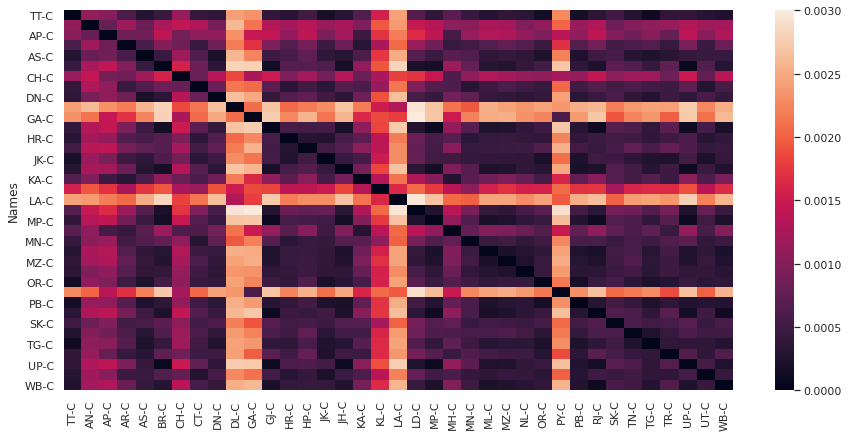

In [ ]:
sns.heatmap(scoreDs) #After Normalisation

In [ ]:
scoreDs.index.name=None
scoreDs

TT-C      AN-C      AP-C  ...      UP-C      UT-C      WB-C
TT-C  0.000000  0.001111  0.001031  ...  0.000383  0.000298  0.000254
AN-C  0.001111  0.000000  0.000793  ...  0.001293  0.001187  0.001224
AP-C  0.001031  0.000793  0.000000  ...  0.001386  0.001025  0.001303
AR-C  0.000593  0.001188  0.000834  ...  0.000932  0.000468  0.000818
AS-C  0.000282  0.000817  0.000874  ...  0.000421  0.000446  0.000432
BR-C  0.000450  0.001251  0.001413  ...  0.000087  0.000635  0.000295
CH-C  0.001134  0.001426  0.000890  ...  0.001486  0.000764  0.001374
CT-C  0.000416  0.001295  0.001082  ...  0.000744  0.000289  0.000563
DN-C  0.000372  0.000925  0.001085  ...  0.000372  0.000557  0.000417
DL-C  0.002416  0.002612  0.002322  ...  0.002754  0.002262  0.002525
GA-C  0.002329  0.002120  0.001454  ...  0.002744  0.002105  0.002607
GJ-C  0.000391  0.001320  0.001433  ...  0.000110  0.000541  0.000202
HR-C  0.000328  0.001221  0.001091  ...  0.000600  0.000305  0.000407
HP-C  0.000514  0.001358  0.001407  ...  0.000616  0.000416  0.000440
JK-C  0.000195  0.001156  0.000943  ...  0.000532  0.000222  0.000420
JH-C  0.000312  0.001247  0.001228  ...  0.000110  0.000469  0.000263
KA-C  0.000641  0.000970  0.000475  ...  0.001042  0.000606  0.000922
KL-C  0.001571  0.001959  0.001718  ...  0.001895  0.001375  0.001657
LA-C  0.002432  0.002386  0.002188  ...  0.002773  0.002209  0.002576
LD-C  0.000645  0.001474  0.001644  ...  0.000238  0.000776  0.000452
MP-C  0.000377  0.001334  0.001413  ...  0.000095  0.000509  0.000226
MH-C  0.000698  0.001068  0.000540  ...  0.001104  0.000580  0.000995
MN-C  0.000438  0.001049  0.001137  ...  0.000719  0.000405  0.000491
ML-C  0.000301  0.001269  0.001320  ...  0.000252  0.000374  0.000217
MZ-C  0.000381  0.001209  0.001304  ...  0.000264  0.000428  0.000267
NL-C  0.000344  0.000965  0.001097  ...  0.000392  0.000401  0.000318
OR-C  0.000145  0.001103  0.000960  ...  0.000447  0.000336  0.000385
PY-C  0.002274  0.002022  0.001369  ...  0.002657  0.002017  0.002560
PB-C  0.000171  0.001135  0.001091  ...  0.000280  0.000295  0.000287
RJ-C  0.000348  0.001310  0.001407  ...  0.000176  0.000495  0.000129
SK-C  0.000498  0.000823  0.000987  ...  0.000688  0.000453  0.000564
TN-C  0.000271  0.001005  0.000877  ...  0.000600  0.000504  0.000494
TG-C  0.000127  0.001078  0.001027  ...  0.000378  0.000381  0.000285
TR-C  0.000383  0.001138  0.000794  ...  0.000652  0.000379  0.000629
UP-C  0.000383  0.001293  0.001386  ...  0.000000  0.000549  0.000248
UT-C  0.000298  0.001187  0.001025  ...  0.000549  0.000000  0.000441
WB-C  0.000254  0.001224  0.001303  ...  0.000248  0.000441  0.000000

[37 rows x 37 columns]

/usr/local/lib/python3.6/dist-packages/scipy/cluster/hierarchy.py:360: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



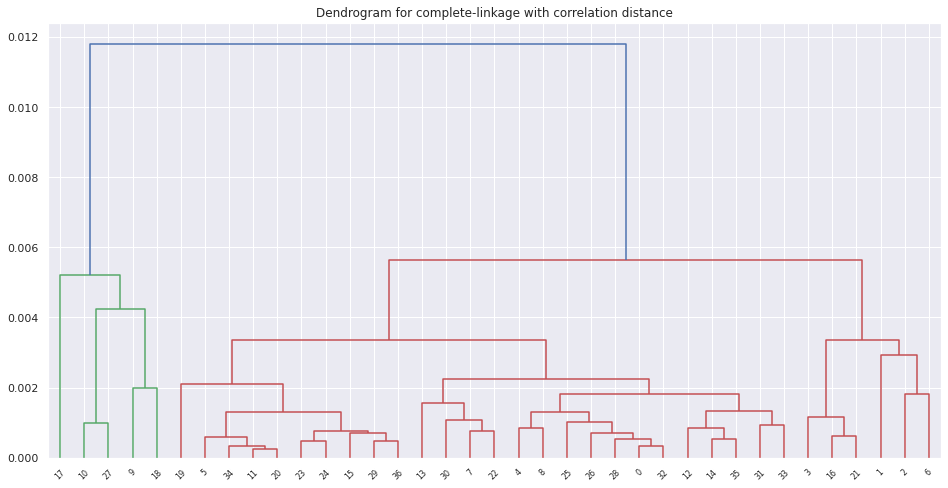

In [ ]:
linkage_matrix = hierarchical_clustering(scoreDs)

In [ ]:
new_array=[3, 4, 4, 4, 3, 2, 4, 3, 3, 1, 1, 2, 3, 3, 3, 2, 4, 1, 1, 2, 2, 4, 3, 2, 2, 3, 3, 1, 3, 2, 3, 3, 3, 3, 2, 3, 2]

[3, 4, 4, 4, 3, 2, 4, 3, 3, 1, 1, 2, 3, 3, 3, 2, 4, 1, 1, 2, 2, 4, 3, 2, 2, 3, 3, 1, 3, 2, 3, 3, 3, 3, 2, 3, 2]

In [ ]:
ind=[[0 for x in range(2)] for y in range(37)]
# print(ind)
for i in range(len(new_array)):
  ind[i][0]=i
  ind[i][1]=new_array[i]
  # print(str(i)+" "+str(new_array[i])+" "+str(ind[i]))
# print(ind)
print(sorted(ind,key=lambda x:x[1]))

[[9, 1], [10, 1], [17, 1], [18, 1], [27, 1], [5, 2], [11, 2], [15, 2], [19, 2], [20, 2], [23, 2], [24, 2], [29, 2], [34, 2], [36, 2], [0, 3], [4, 3], [7, 3], [8, 3], [12, 3], [13, 3], [14, 3], [22, 3], [25, 3], [26, 3], [28, 3], [30, 3], [31, 3], [32, 3], [33, 3], [35, 3], [1, 4], [2, 4], [3, 4], [6, 4], [16, 4], [21, 4]]


[[9, 1], [10, 1], [17, 1], [18, 1], [27, 1], [5, 2], [11, 2], [15, 2], [19, 2], [20, 2], [23, 2], [24, 2], [29, 2], [34, 2], [36, 2], [0, 3], [4, 3], [7, 3], [8, 3], [12, 3], [13, 3], [14, 3], [22, 3], [25, 3], [26, 3], [28, 3], [30, 3], [31, 3], [32, 3], [33, 3], [35, 3], [1, 4], [2, 4], [3, 4], [6, 4], [16, 4], [21, 4]]

In [ ]:
for i in rev_states_map:
  rev_states_map[i]=(rev_states_map[i][0],rev_states_map[i][1],new_array[rev_states_map[i][1]])
rev_states_map

{'AN': ('Andaman and Nicobar Islands', 1, 4),
 'AP': ('Andhra Pradesh', 2, 4),
 'AR': ('Arunachal Pradesh', 3, 4),
 'AS': ('Assam', 4, 3),
 'BR': ('Bihar', 5, 2),
 'CH': ('Chandigarh', 6, 4),
 'CT': ('Chhattisgarh', 7, 3),
 'DL': ('Delhi', 9, 1),
 'DN': ('Dadra and Nagar Haveli and Daman and Diu', 8, 3),
 'GA': ('Goa', 10, 1),
 'GJ': ('Gujarat', 11, 2),
 'HP': ('Himachal Pradesh', 13, 3),
 'HR': ('Haryana', 12, 3),
 'JH': ('Jharkhand', 15, 2),
 'JK': ('Jammu and Kashmir', 14, 3),
 'KA': ('Karnataka', 16, 4),
 'KL': ('Kerala', 17, 1),
 'LA': ('Ladakh', 18, 1),
 'LD': ('Lakshadweep', 19, 2),
 'MH': ('Maharashtra', 21, 4),
 'ML': ('Meghalaya', 23, 2),
 'MN': ('Manipur', 22, 3),
 'MP': ('Madhya Pradesh', 20, 2),
 'MZ': ('Mizoram', 24, 2),
 'NL': ('Nagaland', 25, 3),
 'OR': ('Odisha', 26, 3),
 'PB': ('Punjab', 28, 3),
 'PY': ('Puducherry', 27, 1),
 'RJ': ('Rajasthan', 29, 2),
 'SK': ('Sikkim', 30, 3),
 'TG': ('Telangana', 32, 3),
 'TN': ('Tamil Nadu', 31, 3),
 'TR': ('Tripura', 33, 3),
 'UP

{'AN': ('Andaman and Nicobar Islands', 1, 4)

 'AP': ('Andhra Pradesh', 2, 4)

 'AR': ('Arunachal Pradesh', 3, 4),

 'AS': ('Assam', 4, 3),

 'BR': ('Bihar', 5, 2),

 'CH': ('Chandigarh', 6, 4),

 'CT': ('Chhattisgarh', 7, 3),

 'DL': ('Delhi', 9, 1),

 'DN': ('Dadra and Nagar Haveli and Daman and Diu', 8, 3),

 'GA': ('Goa', 10, 1),

 'GJ': ('Gujarat', 11, 2),

 'HP': ('Himachal Pradesh', 13, 3),

 'HR': ('Haryana', 12, 3),

 'JH': ('Jharkhand', 15, 2),

 'JK': ('Jammu and Kashmir', 14, 3),

 'KA': ('Karnataka', 16, 4),

 'KL': ('Kerala', 17, 1),

 'LA': ('Ladakh', 18, 1),

 'LD': ('Lakshadweep', 19, 2),

 'MH': ('Maharashtra', 21, 4),

 'ML': ('Meghalaya', 23, 2),

 'MN': ('Manipur', 22, 3),

 'MP': ('Madhya Pradesh', 20, 2),

 'MZ': ('Mizoram', 24, 2),

 'NL': ('Nagaland', 25, 3),

 'OR': ('Odisha', 26, 3),

 'PB': ('Punjab', 28, 3),

 'PY': ('Puducherry', 27, 1),

 'RJ': ('Rajasthan', 29, 2),

 'SK': ('Sikkim', 30, 3),

 'TG': ('Telangana', 32, 3),

 'TN': ('Tamil Nadu', 31, 3),

 'TR': ('Tripura', 33, 3),

 'UP': ('Uttar Pradesh', 34, 2),

 'UT': ('Uttarakhand', 35, 3),

 'WB': ('West Bengal', 36, 2)}


# With Constrains of r=7

## Cluster 1 - 18,9,10,27

* Ladakh
* Delhi
* Goa
* Puducherry

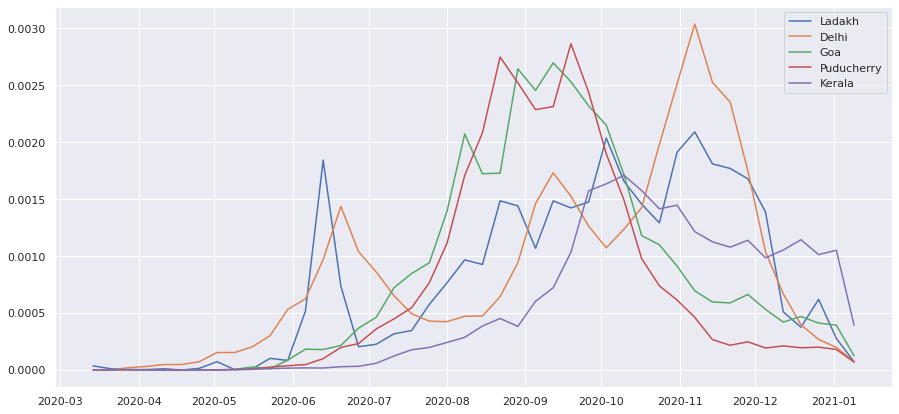

In [ ]:
plt.plot(normalised_ds["LA-C"].resample('7D').sum(),label="Ladakh")
plt.plot(normalised_ds["DL-C"].resample('7D').sum(),label="Delhi")
plt.plot(normalised_ds["GA-C"].resample('7D').sum(),label="Goa")
plt.plot(normalised_ds["PY-C"].resample('7D').sum(),label="Puducherry")
plt.plot(normalised_ds["KL-C"].resample('7D').sum(),label="Kerala")
plt.legend()

## Characteristics of Cluster 1


* Highly unreliable
* Random crests and troughs
* That's the reason we're getting states which apparently have nothing in common

## Who is the representative?

Delhi


## Cluster 2 - 17,30,...,6

* Kerala
* Sikkim
* Karanataka
* Arunachal Pradesh
* Mahrashtra
* Andhra Pradesh
* Andaman n Nicobar
* Chandigarh


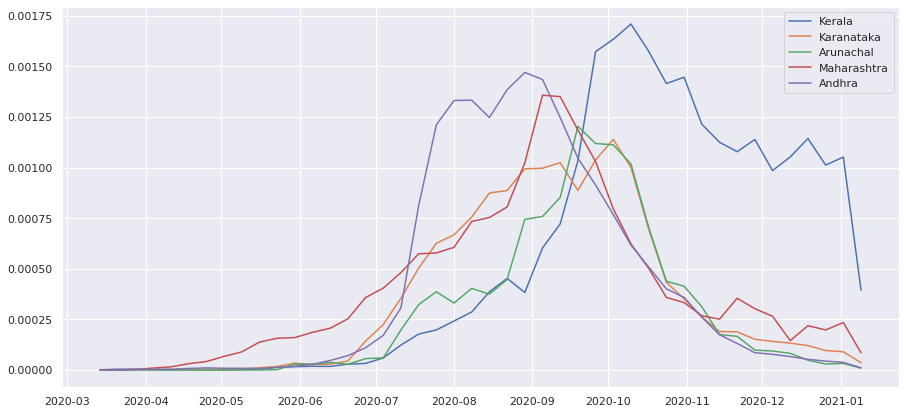

In [ ]:
plt.plot(normalised_ds["KL-C"].resample('7D').sum(),label="Kerala")
#plt.plot(normalised_ds["SK-C"],label="Sikkim")
#plt.plot(normalised_ds["MH-C"])
plt.plot(normalised_ds["KA-C"].resample('7D').sum(),label="Karanataka")
plt.plot(normalised_ds["AR-C"].resample('7D').sum(),label="Arunachal")
plt.plot(normalised_ds["MH-C"].resample('7D').sum(),label="Maharashtra")
plt.plot(normalised_ds["AP-C"].resample('7D').sum(),label="Andhra")
#plt.plot(normalised_ds["AN-C"],label="Andaman n Nicobar")
#plt.plot(normalised_ds["CH-C"].resample('7D'),label="Chandigrah")
plt.legend()



In [ ]:
normalised_ds.where(normalised_ds["MH-C"]<0).dropna()

TT-C      AN-C     AP-C  ...      UP-C      UT-C      WB-C
Date                                     ...                              
2020-12-16  0.000015  0.000021  0.00001  ...  0.000006  0.000056  0.000025

[1 rows x 37 columns]

In [ ]:
normalised_ds["MH-C"]["2020-12-16"]=5.26276761082088e-05

## Characteristics of Cluster 2


* The commented states showed anomalous shape as compared to the general shape of the cluster and thats the reason why it disappers from this cluster after r=7

* A sharp consistent rise to the peak at around mid-September and a similar sharp consistent decline by Jan 2021

* Might be considered the hostspot cluster

## Who is the representative?

Maharashtra


## Cluster 3 : 15,...,24

* Jharkahand
* Dadar n Nagar Haveli
* Punjab
* India
* Telangana
* Odisha
* Tamil Nadu
* Chhtaisgarh
* Manipur
* Tripura
* Uttrakhand
* Harayana
* Assam
* Himachal Pradesh
* J&K
* Nagaland
* Meghalya
* Mizoram


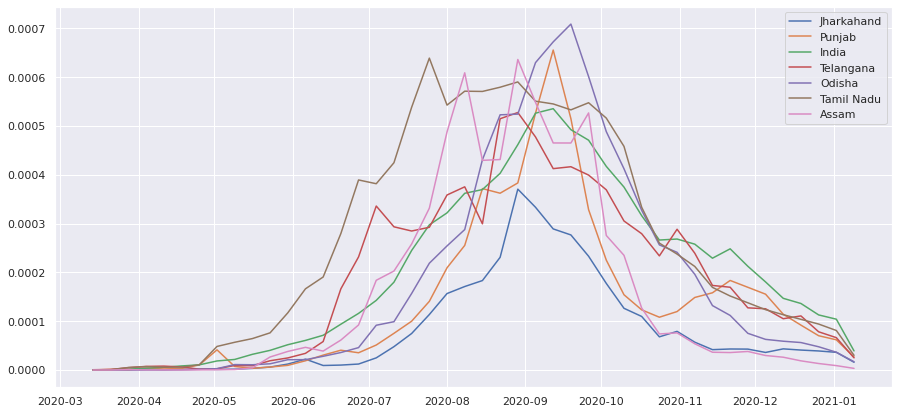

In [ ]:
plt.plot(normalised_ds["JH-C"].resample('7D').sum(),label="Jharkahand")
plt.plot(normalised_ds["PB-C"].resample('7D').sum(),label="Punjab")
plt.plot(normalised_ds["TT-C"].resample('7D').sum(),label="India")
plt.plot(normalised_ds["TG-C"].resample('7D').sum(),label="Telangana")
plt.plot(normalised_ds["OR-C"].resample('7D').sum(),label="Odisha")
plt.plot(normalised_ds["TN-C"].resample('7D').sum(),label="Tamil Nadu")
#plt.plot(normalised_ds["CT-C"],label="Chhtaisgarh")
#plt.plot(normalised_ds["UT-C"],label="Uttrakhand")
#plt.plot(normalised_ds["HR-C"],label="Harayana")
plt.plot(normalised_ds["AS-C"].resample('7D').sum(),label="Assam")
plt.legend()


## Characteristics of Cluster 3


* A not so steep rise to the peak (with some irregularities) and a similar gradual decline.

* Might be considered OK states and resembling the country in general

## Who is the representative?

India


## Cluster 4 - 19, ... , 36

* Lakswadeep
* Gujarat
* Bihar
* Uttar Pradesh
* Madhya Pradesh
* Rajasthan
* West Bengal


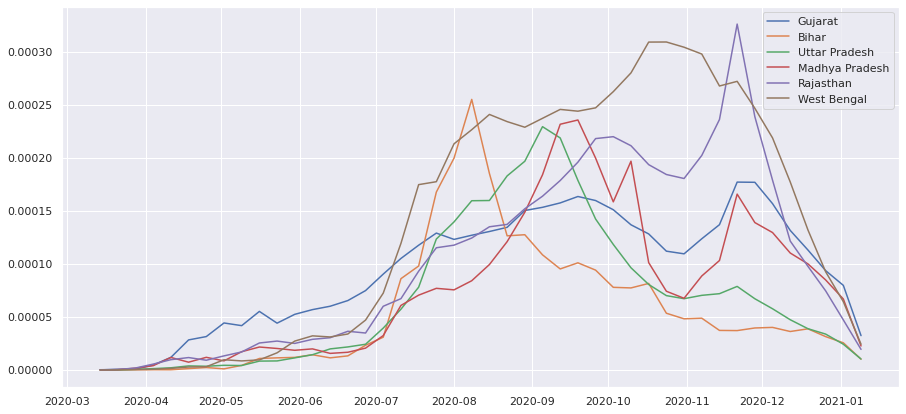

In [ ]:

#plt.plot(normalised_ds["LD-C"],label="Lakswadeep")
plt.plot(normalised_ds["GJ-C"].resample('7D').sum(),label="Gujarat")
plt.plot(normalised_ds["BR-C"].resample('7D').sum(),label="Bihar")
plt.plot(normalised_ds["UP-C"].resample('7D').sum(),label="Uttar Pradesh")
plt.plot(normalised_ds["MP-C"].resample('7D').sum(),label="Madhya Pradesh")
plt.plot(normalised_ds["RJ-C"].resample('7D').sum(),label="Rajasthan")
plt.plot(normalised_ds["WB-C"].resample('7D').sum(),label="West Bengal")

plt.legend()



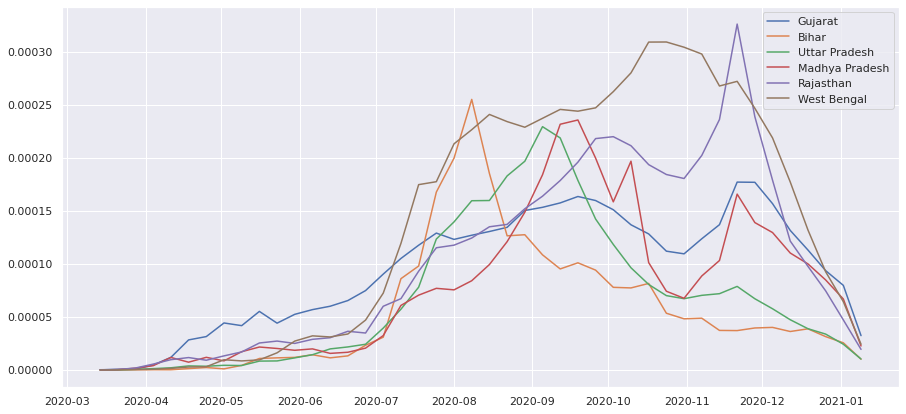

In [ ]:

#plt.plot(normalised_ds["LD-C"],label="Lakswadeep")
plt.plot(normalised_ds["GJ-C"].resample('7D').sum(),label="Gujarat")
plt.plot(normalised_ds["BR-C"].resample('7D').sum(),label="Bihar")
plt.plot(normalised_ds["UP-C"].resample('7D').sum(),label="Uttar Pradesh")
plt.plot(normalised_ds["MP-C"].resample('7D').sum(),label="Madhya Pradesh")
plt.plot(normalised_ds["RJ-C"].resample('7D').sum(),label="Rajasthan")
plt.plot(normalised_ds["WB-C"].resample('7D').sum(),label="West Bengal")

plt.legend()



## Characteristics of Cluster 4


* No visually sharp peak - a plateau like curve
* Represents the Hindi Heartland States
* Might be correlated with the regional festivals

## Who is the representative?

Madhya Pradesh



# Changes With Constraint of r = 7

## Cluster 1 - Unreliable

Everything remains same except an addition of new member - Kerala (17)

## Cluster 2 -  Sharp Rise n Decline

Everything remains same except that Kerala (17) and Sikkim(30) went out

## Cluster 3 - OK states - Moderate Rise n Decline

Everything remains same except that Jharkhand(15), Meghalaya(23) and Mizoram(24) went out and Sikkim(30) came in


## Cluster 4 - Plateau and Hindi States

Everything remains same except that Jharkhand(15), Meghalaya(23) and Mizoram(24) came in

# Inter Cluster Plot with one representation from each cluster

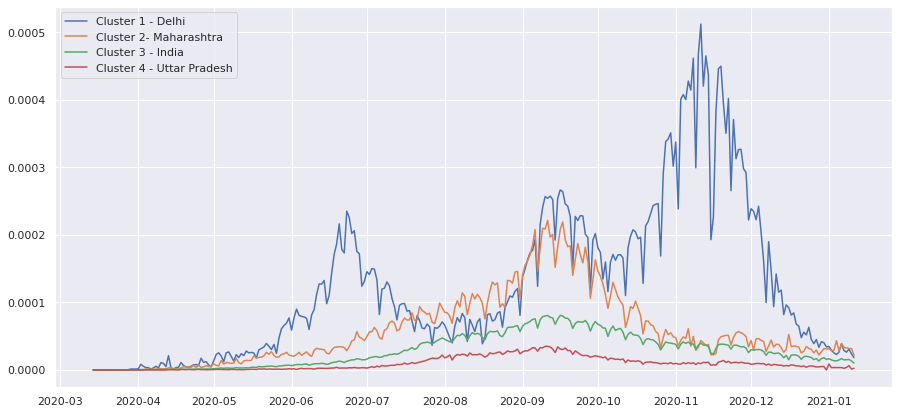

In [ ]:
plt.plot(normalised_ds["DL-C"],label="Cluster 1 - Delhi")
plt.plot(normalised_ds["MH-C"],label="Cluster 2- Maharashtra")
plt.plot(normalised_ds["TT-C"],label="Cluster 3 - India")
plt.plot(normalised_ds["UP-C"],label="Cluster 4 - Uttar Pradesh")
#plt.plot(normalised_ds["KL-C"],label="Kerala")
plt.legend()

In [ ]:
normalised_ds["MH-C"]

Date
2020-03-14    1.245836e-07
2020-03-15    1.601789e-07
2020-03-16    5.339298e-08
2020-03-17    2.669649e-08
2020-03-18    2.669649e-08
                  ...     
2021-01-07    3.318373e-05
2021-01-08    3.286338e-05
2021-01-09    3.186671e-05
2021-01-10    3.166203e-05
2021-01-11    2.169535e-05
Name: MH-C, Length: 304, dtype: float64

Next Meeting

1. District wise cluster graphs
2. Smoothen the curves - 7 days
3. Make r=7 as the primary
4. Colour India's map acc to the cluster

Stretch Goals

1. KMeans Clustering by putting k=3,4,5
2. Analysing deceased data

In [ ]:
import json
import numpy as np
import pandas as pd
import plotly.express as px

In [ ]:
# import plotly.io as pio
# pio.renderers.default = 'browser'

In [ ]:
india_states = json.load(open("/content/drive/MyDrive/Covid19ClusterPrediction/states_india.geojson", "r"))

In [ ]:
state_id_map = {}
for feature in india_states["features"]:
    feature["id"] = feature["properties"]["state_code"]
    state_id_map[feature["properties"]["st_nm"]] = feature["id"]

In [ ]:
state_id_map

In [ ]:
len(state_id_map)

{'AN': ('Andaman and Nicobar Islands', 1, 4)

 'AP': ('Andhra Pradesh', 2, 4)

 'AR': ('Arunachal Pradesh', 3, 4),

 'AS': ('Assam', 4, 3),

 'BR': ('Bihar', 5, 2),

 'CH': ('Chandigarh', 6, 4),

 'CT': ('Chhattisgarh', 7, 3),

 'DL': ('Delhi', 9, 1),

 'DN': ('Dadra and Nagar Haveli and Daman and Diu', 8, 3),

 'GA': ('Goa', 10, 1),

 'GJ': ('Gujarat', 11, 2),

 'HP': ('Himachal Pradesh', 13, 3),

 'HR': ('Haryana', 12, 3),

 'JH': ('Jharkhand', 15, 2),

 'JK': ('Jammu and Kashmir', 14, 3),

 'KA': ('Karnataka', 16, 4),

 'KL': ('Kerala', 17, 1),

 'LA': ('Ladakh', 18, 1),

 'LD': ('Lakshadweep', 19, 2),

 'MH': ('Maharashtra', 21, 4),

 'ML': ('Meghalaya', 23, 2),

 'MN': ('Manipur', 22, 3),

 'MP': ('Madhya Pradesh', 20, 2),

 'MZ': ('Mizoram', 24, 2),

 'NL': ('Nagaland', 25, 3),

 'OR': ('Odisha', 26, 3),

 'PB': ('Punjab', 28, 3),

 'PY': ('Puducherry', 27, 1),

 'RJ': ('Rajasthan', 29, 2),

 'SK': ('Sikkim', 30, 3),

 'TG': ('Telangana', 32, 3),

 'TN': ('Tamil Nadu', 31, 3),

 'TR': ('Tripura', 33, 3),

 'UP': ('Uttar Pradesh', 34, 2),

 'UT': ('Uttarakhand', 35, 3),

 'WB': ('West Bengal', 36, 2)}


In [ ]:
state_name=[]
state_id=[]
state_cluster_id=[]

In [ ]:
temp=[]
cnt=0
for i in rev_states_map:
  if (rev_states_map[i][0] in state_id_map):
    # print(str(rev_states_map[i])+" "+str(state_id_map[rev_states_map[i][0]]))
    state_name.append(rev_states_map[i][0])
    state_id.append(state_id_map[rev_states_map[i][0]])
    state_cluster_id.append(rev_states_map[i][2])
  else:
    print(str(rev_states_map[i])+" NONE")
    state_name.append(rev_states_map[i][0])
    state_id.append(-1)
    state_cluster_id.append(rev_states_map[i][2])
    temp.append(cnt)
  cnt+=1

In [ ]:
print(temp)

In [ ]:
state_id[0]=35
state_id[2]=12
state_id[7]=26
state_id[8]=7
state_id[13]=1

In [ ]:
del(state_name[17])
del(state_cluster_id[17])
del(state_id[17])

In [ ]:
for i in range(len(state_cluster_id)):
  print(str(state_name[i])+" "+str(state_id[i])+" "+str(state_cluster_id[i]))

In [ ]:
lis=[0,1,5,2,4,8]
del(lis[2])
print(lis)

In [ ]:
len(rev_states_map)

In [ ]:
coldf=pd.DataFrame(data={"Name": state_name, "State Code":state_id, "State Cluster Number":state_cluster_id})

In [ ]:
coldf.head()

In [ ]:
fig = px.choropleth_mapbox(
    coldf,
    locations="State Code",
    geojson=india_states,
    color="State Cluster Number",
    hover_name="State Cluster Number",
    hover_data=["State Cluster Number"],
    mapbox_style="carto-positron",
    center={"lat": 24, "lon": 78},
    zoom=3,
    opacity=0.5,
)
# fig.update_geos(fitbounds="locations", visible=False)/
fig.show()

In [ ]:
cluster1=[21,251,210,328,134,396,617,618,635,243,626,246,321]
cluster2=[166,25,391,314,223,488,163,468,15,88,219,77,218,225,24,357,72,156,371,217,495,170,214,611,216,326,442,145,178,92,187,71,385,174,175,643,139,583,374,376,13,179,165,80,482,393,341,380,490,140,480,215,390,129,411,334,201,307,319,641,456,494,578,489,309,157,325,146,478,630,231,365,79,135,581,392,213,440,73,147,525,65,486,160,311,584,615,226,233,360,23,340,330,306,375,388,336,370,221,312,462,479,333,621,406,426,622,149,94,368,22,176,181,350,600,4,639,90,620,235,473,270,399,69,400,408,151,492,460,222,634,228,313,638,574,173,206]

In [ ]:
cluster2.index(206)

In [ ]:
breakpoints=[321,206,441,234,324,454]

In [ ]:
index=[-1]
for i in range(len(breakpoints)):
  index.append(labels.index(breakpoints[i]))

In [ ]:
clusters=[]
for i in range(len(index)):
  clusters.append(labels[index[i-1]+1:index[i]+1])

In [ ]:
!pip install geopandas

     |████████████████████████████████| 1.0MB 2.8MB/s 
     |████████████████████████████████| 6.5MB 39.1MB/s 
     |████████████████████████████████| 14.8MB 316kB/s 


In [ ]:
import geopandas as gpd

In [ ]:
district_map_df = gpd.read_file('/content/drive/MyDrive/Covid19ClusterPrediction/India_States_and_Districts/c44c9b96-f570-4ee3-97f1-ebad64efa4c2202044-1-1rb4x6s.8xx6.shp')
district_map_df.head()

objectid  ...                                           geometry
0         1  ...  POLYGON ((75.23335 21.41481, 75.23469 21.41453...
1         2  ...  POLYGON ((74.13013 20.86311, 74.13215 20.86160...
2         3  ...  POLYGON ((79.75755 20.73462, 79.76047 20.73463...
3         4  ...  POLYGON ((78.26132 20.69735, 78.26276 20.69717...
4         5  ...  POLYGON ((78.05387 19.92452, 78.05449 19.92435...

[5 rows x 10 columns]

In [ ]:
len(district_map_df)

727

In [ ]:
district_map_df["distname"].iloc[417]="Raigad"

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
district_map_df[district_map_df['distname']=="Raigad"]

objectid  ...                                           geometry
417       418  ...  POLYGON ((73.52538 19.12940, 73.52496 19.12858...

[1 rows x 10 columns]

In [ ]:
state_map_df=gpd.read_file('/content/drive/MyDrive/Covid19ClusterPrediction/India_States_and_Districts/india-polygon.shp')
state_map_df.tail()

id              st_nm                                           geometry
32  None        West Bengal  MULTIPOLYGON (((88.22156 21.76255, 88.31155 21...
33  None             Odisha  POLYGON ((86.72769 22.21848, 86.72094 22.14704...
34  None     Andhra Pradesh  POLYGON ((81.10545 17.82313, 81.39342 17.81473...
35  None  Jammu and Kashmir  POLYGON ((74.09957 35.14187, 74.52028 35.10615...
36  None             Ladakh  POLYGON ((76.79483 33.25515, 76.39662 33.66695...

In [ ]:
len(state_map_df)

37

--------------------------------------------------------------------------

For Plotting the Deceased Data on National Map

In [ ]:
dd=({
    1: ["Goa","Puducherry","Delhi","Ladakh"],
    2: ["Maharashtra","Andaman and Nicobar Islands","Chandigarh","Sikkim"],
    3: ["Mizoram","Bihar", "Dadra and Nagar Haveli and Daman and Diu","Lakshwadeep","Gujarat","Rajasthan","Telangana","Odisha",\
        "Madhya Pradesh","Uttar Pradesh","Assam","Jharkhand","Meghalaya","Arunachal Pradesh","Nagaland","India","West Bengal","Haryana","Kerala"],
    4: ["Uttarakhand","Chhattisgarh","Himachal Pradesh","Manipur","Karnataka","Punjab","Jammu and Kashmir","Tripura","Andhra Pradesh","Tamil Nadu"]
})

In [ ]:
rev_dd=dict({})
for key in dd:
  for val in dd[key]:
    rev_dd[val]=key

In [ ]:
merged_df=state_map_df

In [ ]:
merged_df["Cluster_Code"]=[1 for x in range(len(merged_df))]

In [ ]:
merged_df.rename(columns={"st_nm": "name"}, inplace=True)

In [ ]:
merged_df.drop(labels="id",axis=1,inplace=True)
merged_df

name  ... Cluster_Code
0   Andaman and Nicobar Islands  ...            1
1             Arunachal Pradesh  ...            1
2                         Assam  ...            1
3                         Bihar  ...            1
4                    Chandigarh  ...            1
5                  Chhattisgarh  ...            1
6        Dadra and Nagar Haveli  ...            1
7                 Daman and Diu  ...            1
8                           Goa  ...            1
9                       Gujarat  ...            1
10                      Haryana  ...            1
11             Himachal Pradesh  ...            1
12                    Jharkhand  ...            1
13                    Karnataka  ...            1
14                       Kerala  ...            1
15                  Lakshadweep  ...            1
16               Madhya Pradesh  ...            1
17                  Maharashtra  ...            1
18                      Manipur  ...            1
19                    Meghalaya  ...            1
20                      Mizoram  ...            1
21                     Nagaland  ...            1
22                        Delhi  ...            1
23                   Puducherry  ...            1
24                       Punjab  ...            1
25                    Rajasthan  ...            1
26                       Sikkim  ...            1
27                   Tamil Nadu  ...            1
28                    Telangana  ...            1
29                      Tripura  ...            1
30                Uttar Pradesh  ...            1
31                  Uttarakhand  ...            1
32                  West Bengal  ...            1
33                       Odisha  ...            1
34               Andhra Pradesh  ...            1
35            Jammu and Kashmir  ...            1
36                       Ladakh  ...            1

[37 rows x 3 columns]

In [ ]:
for i in range(len(merged_df)):
  if (merged_df["name"].iloc[i] in rev_dd):
    merged_df["Cluster_Code"].iloc[i]=rev_dd[merged_df["name"].iloc[i]]
  else:
    print(merged_df["name"].iloc[i])

Dadra and Nagar Haveli
Daman and Diu
Lakshadweep


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
merged_df["Cluster_Code"].iloc[6]=3
merged_df["Cluster_Code"].iloc[7]=3
merged_df["Cluster_Code"].iloc[15]=3

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
merged_df

name  ... Cluster_Code
0   Andaman and Nicobar Islands  ...            2
1             Arunachal Pradesh  ...            3
2                         Assam  ...            3
3                         Bihar  ...            3
4                    Chandigarh  ...            2
5                  Chhattisgarh  ...            4
6        Dadra and Nagar Haveli  ...            3
7                 Daman and Diu  ...            3
8                           Goa  ...            1
9                       Gujarat  ...            3
10                      Haryana  ...            3
11             Himachal Pradesh  ...            4
12                    Jharkhand  ...            3
13                    Karnataka  ...            4
14                       Kerala  ...            3
15                  Lakshadweep  ...            3
16               Madhya Pradesh  ...            3
17                  Maharashtra  ...            2
18                      Manipur  ...            4
19                    Meghalaya  ...            3
20                      Mizoram  ...            3
21                     Nagaland  ...            3
22                        Delhi  ...            1
23                   Puducherry  ...            1
24                       Punjab  ...            4
25                    Rajasthan  ...            3
26                       Sikkim  ...            2
27                   Tamil Nadu  ...            4
28                    Telangana  ...            3
29                      Tripura  ...            4
30                Uttar Pradesh  ...            3
31                  Uttarakhand  ...            4
32                  West Bengal  ...            3
33                       Odisha  ...            3
34               Andhra Pradesh  ...            4
35            Jammu and Kashmir  ...            4
36                       Ladakh  ...            1

[37 rows x 3 columns]

------------------------------------------------------------------------------

------------------------------------------------------------------

Solely For New Cases in Punjab and its Districts

In [ ]:
punjab_dist=district_map_df[district_map_df["statename"]=="TAMIL NADU"]
punjab_dist=punjab_dist[["distname",'geometry']].copy().rename(columns={"distname": "name"})\
.append((state_map_df[state_map_df["st_nm"]=="Tamil Nadu"][["st_nm","geometry"]].copy().rename(columns={"st_nm":"name"})),ignore_index=True)
punjab_dist

name                                           geometry
0           Vellore  POLYGON ((79.65695 13.21040, 79.66117 13.21045...
1           Chennai  POLYGON ((80.26314 13.14996, 80.26510 13.14951...
2      Kancheepuram  POLYGON ((79.98676 13.05611, 79.98707 13.05593...
3    Tiruvannamalai  POLYGON ((79.47523 12.87357, 79.47851 12.87266...
4             Erode  POLYGON ((77.65349 11.95477, 77.65517 11.95423...
5        Coimbatore  POLYGON ((77.11024 11.40645, 77.11062 11.40621...
6        Thiruvarur  POLYGON ((79.67385 11.01648, 79.67549 11.01681...
7           Madurai  POLYGON ((78.37476 10.31036, 78.37516 10.31028...
8             Theni  POLYGON ((77.62242 10.21880, 77.62292 10.21878...
9      Thoothukkudi  MULTIPOLYGON (((78.16140 9.36991, 78.16357 9.3...
10    Kanniyakumari  MULTIPOLYGON (((77.27959 8.57060, 77.28022 8.5...
11       Perambalur  POLYGON ((78.85789 11.52317, 78.85989 11.52199...
12         Tiruppur  POLYGON ((77.21906 11.35223, 77.21958 11.35213...
13       Dharmapuri  POLYGON ((77.94398 12.51184, 77.94625 12.50922...
14            Salem  POLYGON ((78.23479 11.97932, 78.23483 11.97932...
15  Tiruchirappalli  POLYGON ((78.49605 11.40895, 78.49623 11.40895...
16        Thanjavur  POLYGON ((79.52733 11.18288, 79.52858 11.18143...
17            Karur  POLYGON ((77.99644 11.09688, 77.99675 11.09683...
18      Tirunelveli  POLYGON ((77.33978 9.42005, 77.33984 9.42017, ...
19      Thiruvallur  POLYGON ((80.26896 13.56474, 80.26904 13.56445...
20      Krishnagiri  POLYGON ((77.93009 12.89036, 77.93097 12.88966...
21     The Nilgiris  POLYGON ((76.51162 11.70510, 76.51163 11.70510...
22         Namakkal  POLYGON ((78.43958 11.59815, 78.44031 11.59811...
23         Ariyalur  POLYGON ((79.32252 11.41965, 79.32263 11.41928...
24         Dindigul  POLYGON ((78.17516 10.83523, 78.17597 10.83520...
25     Virudhunagar  POLYGON ((78.10693 9.78616, 78.10702 9.78608, ...
26       Viluppuram  POLYGON ((79.32610 12.45062, 79.32736 12.45030...
27      Pudukkottai  MULTIPOLYGON (((78.69345 10.73277, 78.69421 10...
28        Sivaganga  MULTIPOLYGON (((78.47281 10.40116, 78.47428 10...
29     Nagapattinam  MULTIPOLYGON (((79.72238 10.92908, 79.72258 10...
30        Cuddalore  MULTIPOLYGON (((79.70101 11.88922, 79.70277 11...
31   Ramanathapuram  MULTIPOLYGON (((78.99467 9.94046, 78.99603 9.9...
32       Tamil Nadu  MULTIPOLYGON (((79.78256 11.89825, 79.79156 11...

In [ ]:
# dd={1: [],
#  4: ['Faridkot',
#   'Pathankot',
#   'Bathinda',
#   'Ludhiana',
#   'Jalandhar',
#   'S.A.S. Nagar'],
#  3: ['Sangrur', 'Tarn Taran','Punjab'],
#  2: ['Sri Muktsar Sahib',
#   'Patiala',
#   'Barnala',
#   'Amritsar',
#   'Fatehgarh Sahib',
#   'Mansa',
#   'Kapurthala',
#   'Shahid Bhagat Singh Nagar',
#   'Hoshiarpur',
#   'Gurdaspur',
#   'Moga',
#   'Fazilka',
#   'Rupnagar',
#   'Ferozepur']}

In [ ]:
dd={1: ['Kancheepuram'],
 2: ['Nilgiris',
  'Cuddalore',
  'Kanyakumari',
  'Kallakurichi',
  'Thoothukkudi',
  'Thiruvallur',
  'Thiruvarur',
  'Salem',
  'Virudhunagar',
  'Tirunelveli',
  'Vellore',
  'Coimbatore',
  'Theni',
  'Chengalpattu',
  'Ranipet',
  'Chennai'],
 3: [],
 4: ['Krishnagiri',
  'Pudukkottai',
  'Erode',
  'Viluppuram',
  'Tirupathur',
  'Nagapattinam',
  'Sivaganga',
  'Madurai',
  'Perambalur',
  'Ariyalur',
  'Ramanathapuram',
  'Thanjavur',
  'Tenkasi',
  'Tiruvannamalai',
  'Dindigul',
  'Dharmapuri',
  'Namakkal',
  'Tiruppur',
  'Karur',
  'Tiruchirappalli']}

In [ ]:
rev_dd=dict({})
for key in dd:
  for val in dd[key]:
    rev_dd[val]=key

In [ ]:
rev_dd

{'Ariyalur': 4,
 'Chengalpattu': 2,
 'Chennai': 2,
 'Coimbatore': 2,
 'Cuddalore': 2,
 'Dharmapuri': 4,
 'Dindigul': 4,
 'Erode': 4,
 'Kallakurichi': 2,
 'Kancheepuram': 1,
 'Kanyakumari': 2,
 'Karur': 4,
 'Krishnagiri': 4,
 'Madurai': 4,
 'Nagapattinam': 4,
 'Namakkal': 4,
 'Nilgiris': 2,
 'Perambalur': 4,
 'Pudukkottai': 4,
 'Ramanathapuram': 4,
 'Ranipet': 2,
 'Salem': 2,
 'Sivaganga': 4,
 'Tenkasi': 4,
 'Thanjavur': 4,
 'Theni': 2,
 'Thiruvallur': 2,
 'Thiruvarur': 2,
 'Thoothukkudi': 2,
 'Tiruchirappalli': 4,
 'Tirunelveli': 2,
 'Tirupathur': 4,
 'Tiruppur': 4,
 'Tiruvannamalai': 4,
 'Vellore': 2,
 'Viluppuram': 4,
 'Virudhunagar': 2}

In [ ]:
punjab_dist["Cluster_Code"]=[1 for x in range(len(punjab_dist))]

In [ ]:
for i in range(len(punjab_dist)):
  if (punjab_dist["name"].iloc[i] in rev_dd):
    punjab_dist["Cluster_Code"].iloc[i]=rev_dd[punjab_dist["name"].iloc[i]]
  else:
    print(punjab_dist["name"].iloc[i])

Kanniyakumari
The Nilgiris
Tamil Nadu


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
punjab_dist

name  ... Cluster_Code
0           Vellore  ...            2
1           Chennai  ...            2
2      Kancheepuram  ...            1
3    Tiruvannamalai  ...            4
4             Erode  ...            4
5        Coimbatore  ...            2
6        Thiruvarur  ...            2
7           Madurai  ...            4
8             Theni  ...            2
9      Thoothukkudi  ...            2
10    Kanniyakumari  ...            1
11       Perambalur  ...            4
12         Tiruppur  ...            4
13       Dharmapuri  ...            4
14            Salem  ...            2
15  Tiruchirappalli  ...            4
16        Thanjavur  ...            4
17            Karur  ...            4
18      Tirunelveli  ...            2
19      Thiruvallur  ...            2
20      Krishnagiri  ...            4
21     The Nilgiris  ...            1
22         Namakkal  ...            4
23         Ariyalur  ...            4
24         Dindigul  ...            4
25     Virudhunagar  ...            2
26       Viluppuram  ...            4
27      Pudukkottai  ...            4
28        Sivaganga  ...            4
29     Nagapattinam  ...            4
30        Cuddalore  ...            2
31   Ramanathapuram  ...            4
32       Tamil Nadu  ...            1

[33 rows x 3 columns]

In [ ]:
punjab_dist["Cluster_Code"].iloc[10]=2
punjab_dist["Cluster_Code"].iloc[21]=2
punjab_dist["Cluster_Code"].iloc[32]=4

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
punjab_dist=punjab_dist[::-1]
punjab_dist

name  ... Cluster_Code
32       Tamil Nadu  ...            4
31   Ramanathapuram  ...            4
30        Cuddalore  ...            2
29     Nagapattinam  ...            4
28        Sivaganga  ...            4
27      Pudukkottai  ...            4
26       Viluppuram  ...            4
25     Virudhunagar  ...            2
24         Dindigul  ...            4
23         Ariyalur  ...            4
22         Namakkal  ...            4
21     The Nilgiris  ...            2
20      Krishnagiri  ...            4
19      Thiruvallur  ...            2
18      Tirunelveli  ...            2
17            Karur  ...            4
16        Thanjavur  ...            4
15  Tiruchirappalli  ...            4
14            Salem  ...            2
13       Dharmapuri  ...            4
12         Tiruppur  ...            4
11       Perambalur  ...            4
10    Kanniyakumari  ...            2
9      Thoothukkudi  ...            2
8             Theni  ...            2
7           Madurai  ...            4
6        Thiruvarur  ...            2
5        Coimbatore  ...            2
4             Erode  ...            4
3    Tiruvannamalai  ...            4
2      Kancheepuram  ...            1
1           Chennai  ...            2
0           Vellore  ...            2

[33 rows x 3 columns]

-----------------------------------------------------------------------------

In [ ]:
merged_df

name  ... Cluster_Code
0   Andaman and Nicobar Islands  ...            2
1             Arunachal Pradesh  ...            3
2                         Assam  ...            3
3                         Bihar  ...            3
4                    Chandigarh  ...            2
5                  Chhattisgarh  ...            4
6        Dadra and Nagar Haveli  ...            3
7                 Daman and Diu  ...            3
8                           Goa  ...            1
9                       Gujarat  ...            3
10                      Haryana  ...            3
11             Himachal Pradesh  ...            4
12                    Jharkhand  ...            3
13                    Karnataka  ...            4
14                       Kerala  ...            3
15                  Lakshadweep  ...            3
16               Madhya Pradesh  ...            3
17                  Maharashtra  ...            2
18                      Manipur  ...            4
19                    Meghalaya  ...            3
20                      Mizoram  ...            3
21                     Nagaland  ...            3
22                        Delhi  ...            1
23                   Puducherry  ...            1
24                       Punjab  ...            4
25                    Rajasthan  ...            3
26                       Sikkim  ...            2
27                   Tamil Nadu  ...            4
28                    Telangana  ...            3
29                      Tripura  ...            4
30                Uttar Pradesh  ...            3
31                  Uttarakhand  ...            4
32                  West Bengal  ...            3
33                       Odisha  ...            3
34               Andhra Pradesh  ...            4
35            Jammu and Kashmir  ...            4
36                       Ladakh  ...            1

[37 rows x 3 columns]

In [ ]:
# merged_df["Cluster_Code"].iloc[36]=1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# merged_df[merged_df["name"]=="Ladakh"]

name                                           geometry  Cluster_Code
36  Ladakh  POLYGON ((76.79483 33.25515, 76.39662 33.66695...             1

In [ ]:
import xlrd
import random
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

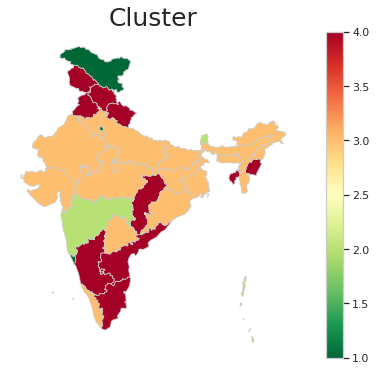

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
ax.set_title('Cluster', fontdict={'fontsize': '25', 'fontweight' : '3'})

# plot the figure
merged_df.plot(column='Cluster_Code', cmap='RdYlGn_r', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True,)

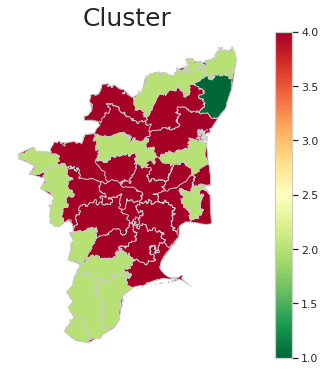

In [ ]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
ax.set_title('Cluster', fontdict={'fontsize': '25', 'fontweight' : '3'})

# plot the figure
punjab_dist.plot(column='Cluster_Code', cmap='RdYlGn_r', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True,)

In [ ]:
import pandas as pd
import numpy as np
import math

import geopandas as gpd
import json

from bokeh.io import output_notebook, show, output_file
output_notebook()
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, NumeralTickFormatter
from bokeh.palettes import brewer

from bokeh.io.doc import curdoc
from bokeh.models import Slider, HoverTool, Select
from bokeh.layouts import widgetbox, row, column

In [ ]:
merged_json = json.loads(merged_df.to_json())

#Convert to str like object
json_data = json.dumps(merged_json)
geosource = GeoJSONDataSource(geojson = json_data)


#Define a sequential multi-hue color palette.
# palette = brewer['RdYlGn'][8]
# #Reverse color order so that dark blue is highest obesity.
# palette = palette[::-1]
palette = ['red', 'yellow', 'purple', 'pink']
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors. Input nan_color.
color_mapper = LinearColorMapper(palette = palette, low = merged_df['Cluster_Code'].min(), high = merged_df['Cluster_Code'].max(), nan_color = '#d9d9d9')
#Define custom tick labels for color bar.
# tick_labels = {'5000': '>5000'}

#Add hover tool
hover = HoverTool(tooltips = [ ('Name','@name'),('Cluster','@Cluster_Code')])
#Create color bar.
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
                     border_line_color=None,location = (0,0), orientation = 'horizontal')
#Create figure object.
pp = figure(title = 'Number of Covid-19 cases', plot_height = 800 , plot_width = 850, toolbar_location = None, tools = [hover])
pp.xaxis.visible = False
pp.yaxis.visible = False
pp.xgrid.grid_line_color = None
pp.ygrid.grid_line_color = None
#Add patch renderer to figure.
pp.patches('xs','ys', source = geosource,fill_color = {'field' :'Cluster_Code', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
#Specify layout
pp.add_layout(color_bar, 'below')

output_file("foo.html")
#Display plot
show(pp)

In [ ]:
merged_json = json.loads(punjab_dist.to_json())

#Convert to str like object
json_data = json.dumps(merged_json)
geosource = GeoJSONDataSource(geojson = json_data)


#Define a sequential multi-hue color palette.
# palette = brewer['RdYlGn'][8]
# #Reverse color order so that dark blue is highest obesity.
# palette = palette[::-1]
palette = ['red','yellow', 'purple', 'pink']
#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors. Input nan_color.
color_mapper = LinearColorMapper(palette = palette, low = punjab_dist['Cluster_Code'].min(), high = punjab_dist['Cluster_Code'].max(), nan_color = '#d9d9d9')
#Define custom tick labels for color bar.
# tick_labels = {'5000': '>5000'}

#Add hover tool
hover = HoverTool(tooltips = [ ('Name','@name'),('Cluster','@Cluster_Code')])
#Create color bar.
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
                     border_line_color=None,location = (0,0), orientation = 'horizontal')
#Create figure object.
pp = figure(title = 'Number of Covid-19 cases', plot_height = 800 , plot_width = 850, toolbar_location = None, tools = [hover])
pp.xaxis.visible = False
pp.yaxis.visible = False
pp.xgrid.grid_line_color = None
pp.ygrid.grid_line_color = None
#Add patch renderer to figure.
pp.patches('xs','ys', source = geosource,fill_color = {'field' :'Cluster_Code', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
#Specify layout
pp.add_layout(color_bar, 'below')

output_file("foo.html")
#Display plot
show(pp)

1 -> 10(red)

2 -> 6(yellow)

3 -> 1(green)

4 -> 3(pink)


In [ ]:
cluster_states_dd=({
    1: ["Goa","Puducherry","Delhi","Ladakh"],
    2: ["Maharashtra","Andaman and Nicobar Islands","Chandigarh","Sikkim"],
    3: ["Mizoram","Bihar", "Dadra and Nagar Haveli and Daman and Diu","Lakshwadeep","Gujarat","Rajasthan","Telangana","Odisha",\
        "Madhya Pradesh","Uttar Pradesh","Assam","Jharkhand","Meghalaya","Arunachal Pradesh","Nagaland","India","West Bengal","Haryana","Kerala"],
    4: ["Uttarakhand","Chhattisgarh","Himachal Pradesh","Manipur","Karnataka","Punjab","Jammu and Kashmir","Tripura","Andhra Pradesh","Tamil Nadu"]
})

In [ ]:
cluster_states={'1': ['Kerala', 'Goa', 'Puducherry', 'Delhi', 'Ladakh'],
 '2': ['Lakshwadeep', 'Bihar', 'Uttar Pradesh', 'Gujarat', 'Madhya Pradesh', 'Meghalaya','Mizoram',
  'Jharkhand',
  'Rajasthan',
  'West Bengal'],
 '3': ['Himachal Pradesh',
  'Sikkim',
  'Chhattisgarh',
  'Manipur',
  'Assam',
  'Dadra and Nagar Haveli and Daman and Diu',
  'Nagaland',
  'Odisha',
  'Punjab',
  'India',
  'Telangana',
  'Haryana',
  'Jammu and Kashmir',
  'Uttarakhand',
  'Tamil Nadu',
  'Tripura'],
 '4': ['Arunachal Pradesh',
  'Karnataka',
  'Maharashtra',
  'Andaman and Nicobar Islands',
  'Andhra Pradesh',
  'Chandigarh']}

In [ ]:
for k in range(1,5):
  for d in range(1,5):
    x1=set()
    x2=set()
    for v in cluster_states_dd[d]:
      if(v not in cluster_states[str(k)]):
        x2.add(v)
    for v in cluster_states[str(k)]:
      if(v not in cluster_states_dd[d]):
        x1.add(v)
    print("infection-"+str(k)+"\\"+" mortality-"+str(d)+" "+str(x1))
    print("mortality-"+str(d)+"\\"+" infection-"+str(k)+" "+str(x2))

infection-1\ mortality-1 {'Kerala'}
mortality-1\ infection-1 set()
infection-1\ mortality-2 {'Puducherry', 'Ladakh', 'Delhi', 'Goa', 'Kerala'}
mortality-2\ infection-1 {'Andaman and Nicobar Islands', 'Sikkim', 'Chandigarh', 'Maharashtra'}
infection-1\ mortality-3 {'Ladakh', 'Goa', 'Puducherry', 'Delhi'}
mortality-3\ infection-1 {'Assam', 'Nagaland', 'India', 'Rajasthan', 'Telangana', 'Madhya Pradesh', 'Jharkhand', 'Uttar Pradesh', 'Meghalaya', 'Haryana', 'Bihar', 'Gujarat', 'Odisha', 'Dadra and Nagar Haveli and Daman and Diu', 'Mizoram', 'West Bengal', 'Lakshwadeep', 'Arunachal Pradesh'}
infection-1\ mortality-4 {'Puducherry', 'Ladakh', 'Delhi', 'Goa', 'Kerala'}
mortality-4\ infection-1 {'Chhattisgarh', 'Jammu and Kashmir', 'Andhra Pradesh', 'Tamil Nadu', 'Himachal Pradesh', 'Manipur', 'Punjab', 'Karnataka', 'Uttarakhand', 'Tripura'}
infection-2\ mortality-1 {'Mizoram', 'Rajasthan', 'Jharkhand', 'Meghalaya', 'Uttar Pradesh', 'Bihar', 'Gujarat', 'Madhya Pradesh', 'Lakshwadeep', 'West Be

In [ ]:
for k in range(1,5):
  for d in range(1,5):
    x1=set(cluster_states[str(k)])
    x2=set(cluster_states_dd[d])
    print("infection-"+str(k)+" A "+"mortality-"+str(chr(ord('A')+d-1))+" "+str(x1.intersection(x2)))

infection-1 A mortality-A {'Delhi', 'Puducherry', 'Goa', 'Ladakh'}
infection-1 A mortality-B set()
infection-1 A mortality-C {'Kerala'}
infection-1 A mortality-D set()
infection-2 A mortality-A set()
infection-2 A mortality-B set()
infection-2 A mortality-C {'Rajasthan', 'Madhya Pradesh', 'Jharkhand', 'Gujarat', 'Lakshwadeep', 'West Bengal', 'Bihar', 'Mizoram', 'Meghalaya', 'Uttar Pradesh'}
infection-2 A mortality-D set()
infection-3 A mortality-A set()
infection-3 A mortality-B {'Sikkim'}
infection-3 A mortality-C {'Assam', 'India', 'Haryana', 'Dadra and Nagar Haveli and Daman and Diu', 'Odisha', 'Telangana', 'Nagaland'}
infection-3 A mortality-D {'Chhattisgarh', 'Tamil Nadu', 'Tripura', 'Uttarakhand', 'Himachal Pradesh', 'Manipur', 'Jammu and Kashmir', 'Punjab'}
infection-4 A mortality-A set()
infection-4 A mortality-B {'Chandigarh', 'Maharashtra', 'Andaman and Nicobar Islands'}
infection-4 A mortality-C {'Arunachal Pradesh'}
infection-4 A mortality-D {'Andhra Pradesh', 'Karnataka'}


In [ ]:
# temp_set=set()
# for k in cluster_states:
#   for v in cluster_states[k]:
#     temp_set.add(v)
# for k in cluster_states_dd:
#   for v in cluster_states_dd[k]:
#     temp_set.add(v)
# len(temp_set)

37

In [ ]:
weights=[[0 for x in range(4)]for y in range(4)]
for k in range(1,5):
  for d in range(1,5):
    s1=set(cluster_states[str(k)])
    s2=set(cluster_states_dd[d])
    weights[k-1][d-1]=len(s1.intersection(s2))/len(s1.union(s2))

In [ ]:
weights

[[0.8, 0.0, 0.043478260869565216, 0.0],
 [0.0, 0.0, 0.5263157894736842, 0.0],
 [0.0, 0.05263157894736842, 0.25, 0.4444444444444444],
 [0.0, 0.42857142857142855, 0.041666666666666664, 0.14285714285714285]]

1->2

1->3

1->4

2->1

3->3

1->B

1->D

2->A

2->B

2->D

3->A

4->A

In [ ]:
from scipy.optimize import linear_sum_assignment

In [ ]:
row_ind, col_ind = linear_sum_assignment(np.array(weights),maximize=True)

In [ ]:
row_ind

array([0, 1, 2, 3])

In [ ]:
col_ind`

array([0, 2, 3, 1])

Infection -> Deceased

1(red)  -> A(red)

2(green) -> C(green)

3(pink) -> D (pink)

4(yellow) -> B(yellow)